<a href="https://colab.research.google.com/github/SeyitKoyuncu/PyTorch-Self-Studying/blob/main/PyTorch_2(Trainin_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

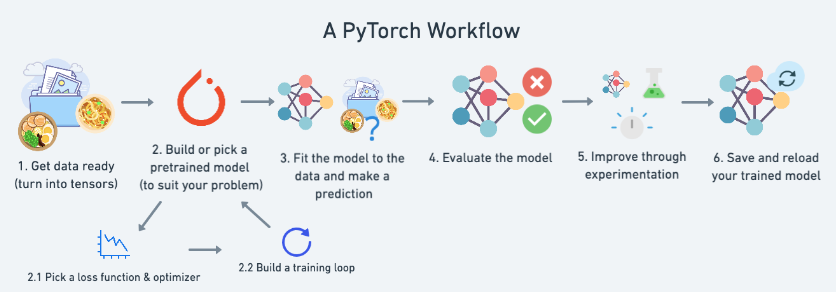

In [1]:
import torch
from torch import nn #nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
print(torch.__version__)

2.0.1+cu118


## Data preaparing and loading

I will use a linear regression formula to make a straight line with *known*
**parameters**

A linear regression line has an equation of the form Y = a + bX, where X is the explanatory variable and Y is the dependent variable. The slope of the line is b, and a is the intercept (the value of y when x = 0).

In [2]:
# Create *known* parameters
weight = 0.7 # weight is the b in the formula
bias = 0.3 # bias is the a in the formula

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1) #unsqueeze add extra dimension
y = weight * X + bias
print(X[:10], y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [3]:
print(len(X), len(y))

50 50


### Splitting data into tranin and test sets
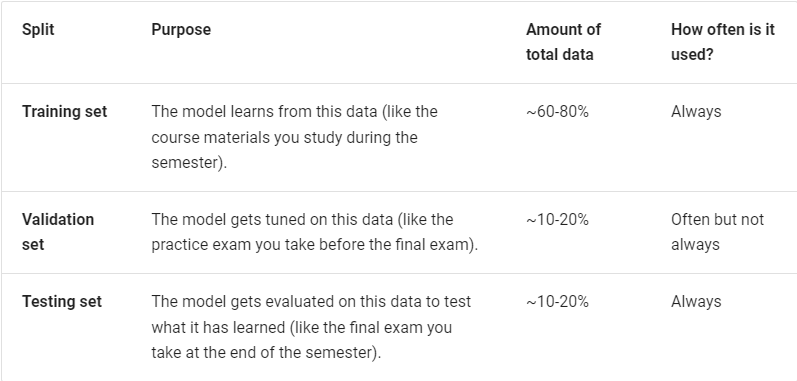

In [4]:
# Create a train/test split
train_split =  int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots trainin data, test data and compares predictions
  """
  plt.figure(figsize = (10, 7))

  # Plot traning data in blue
  plt.scatter(train_data, train_labels, color = "b", s = 4, label = "Train Data")

  # Plot testing data in green
  plt.scatter(test_data, test_labels, color = "g", s = 4, label = "Test Data")

  # Are there predictions
  if predictions is not None:
    # Plot predictions if they exist
    plt.scatter(test_data, predictions, color = "r", s = 4, label = "Predictions")

  # Show legends
  plt.legend(prop={"size": 14})


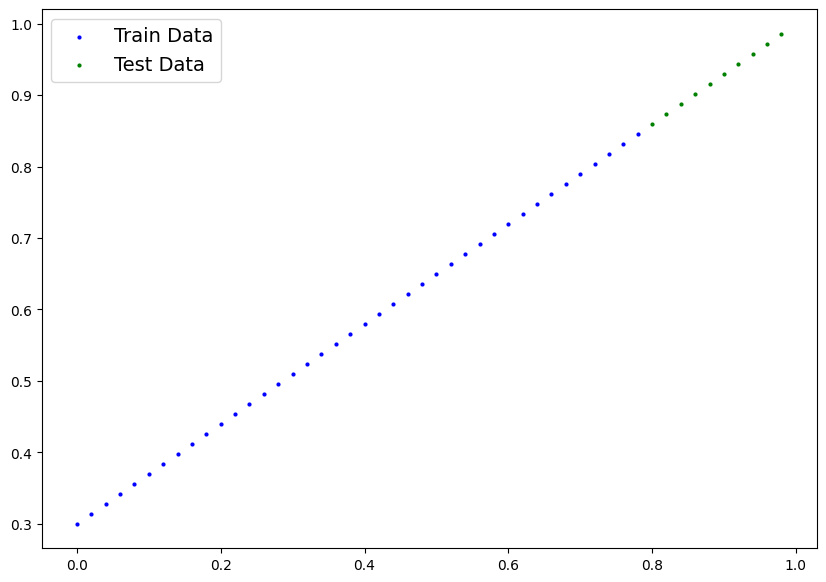

In [6]:
plot_predictions()

## 2. Build model

* Start with a random value (weight and bias)
* Look at training data and adjust the random value to better represent to (or get closer to) the ideal values (the weight and bias values we used to create the data)

How does it do so ?

Through two main algorithm:
1. Gradient descent
2. Backpropagation

### Linear Regression Model

In [7]:
from torch import nn
# Create Linear Regression Model Class
class LinearRegressionModel(nn.Module): # <- Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1,  # <- start with random weights (this will get adjusted as the model learns)
                                           requires_grad = True,
                                           dtype = torch.float)) # <- can we update this value with gradient descent?)

    self.bias = nn.Parameter(torch.rand(1,  # <- start with random weights (this will get adjusted as the model learns)
                                        requires_grad = True,
                                        dtype = torch.float))  # <- can we update this value with gradient descent?)

  # Forward methot to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

We can check our model parameters or whats inside our model using .parameters()

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (subcass of the nn.module)
model_0 = LinearRegressionModel()

# Check out the parameters
print(list(model_0.parameters()))


[Parameter containing:
tensor([0.8823], requires_grad=True), Parameter containing:
tensor([0.9150], requires_grad=True)]


In [9]:
# List named parameters
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])


### Makin prediction using 'toch.inference_mode()'

In [10]:
# Make prediction with model

#uses for speed more info = https://twitter.com/PyTorch/status/1437838231505096708
with torch.inference_mode(): #with torch.inference_mode() disable to usefull things in the training for example gradient methods, we use it because we dont need to gradient methods when we are predicting we need  it when in traning
  y_preds = model_0(X_test)

print(y_preds)

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])


In [11]:
print(y_test)

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


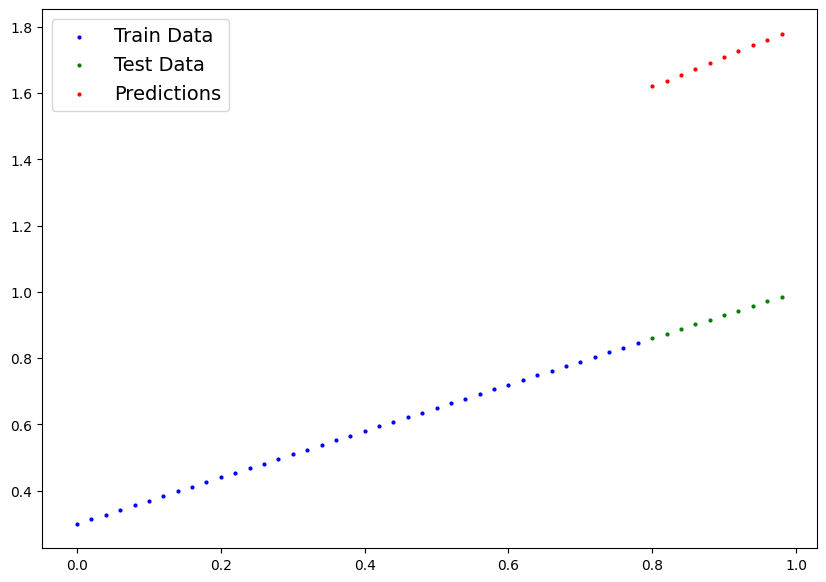

In [12]:
plot_predictions(predictions = y_preds)

## 3.Train Model

* Loss function may called cost function or criterion in different areas

* **Loss Function:** A function to measure how wrong your model's predictions are the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjust the model's parameters(e.g weight & bias) to improve the loss function (https://pytorch.org/docs/stable/optim.html)

Also for PyTorch we need:
* A training loop
* A testing loop

In [13]:
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])


In [14]:
# Setup a loss function
# L1 is the mean absolute error loss function (MAE) = difference between y_pred[0] and y_test[0] => y_pred[0] - y_test[0]
loss_fn = nn.L1Loss()

# Setup a optimizer
# stochastic gradient descent
optimizer = torch.optim.SGD(params = model_0.parameters(), #which parameters does optimizer optimize
                            lr = 0.01) # lr = learning rate = possibily the most important hyperparameter you can set

### Building a training and testing loop in PyTorch

0. Loop through the data
1. Forward pass (this involves data moving through our model's 'forward()' functions) to make predictions - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

**What is gradient** =>
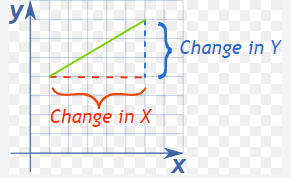 Slope


In [15]:
# An epoch is one loop through the data... (hyper parameter)
epochs = 100

# Track different values
epoch_count = []
train_loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require parameters require gradients

  #1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evulation/testing (dropout/batch norm layers)
  with torch.inference_mode(): #turns of gradient tracking & a couple more things behind the scenes
    #1. Do the forward pass
    test_pred = model_0(X_test)

    #2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test loss: {test_loss}")

# Print out model state_dict()
print(model_0.state_dict())

# Print actual weight and bias
print(weight, bias)

Epoch: 0 | Train Loss: 0.6860889196395874 | Test loss: 0.7637526988983154
Epoch: 10 | Train Loss: 0.5708791017532349 | Test loss: 0.6290428042411804
Epoch: 20 | Train Loss: 0.45566922426223755 | Test loss: 0.4943329691886902
Epoch: 30 | Train Loss: 0.34045934677124023 | Test loss: 0.35962313413619995
Epoch: 40 | Train Loss: 0.2252494841814041 | Test loss: 0.2249133139848709
Epoch: 50 | Train Loss: 0.1100396141409874 | Test loss: 0.09020347893238068
Epoch: 60 | Train Loss: 0.009724985808134079 | Test loss: 0.020998019725084305
Epoch: 70 | Train Loss: 0.006216754671186209 | Test loss: 0.014099234715104103
Epoch: 80 | Train Loss: 0.002788322512060404 | Test loss: 0.005826681852340698
Epoch: 90 | Train Loss: 0.007095950655639172 | Test loss: 0.00754010071977973
OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])
0.7 0.3


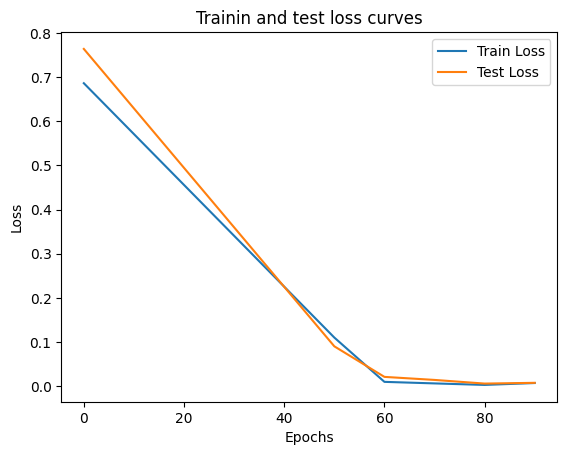

In [16]:
# Plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label = "Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label = "Test Loss")
plt.title("Trainin and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [17]:
with torch.inference_mode(): #turns of gradient tracking & a couple more things behind the scenes
  y_preds_new = model_0(X_test)

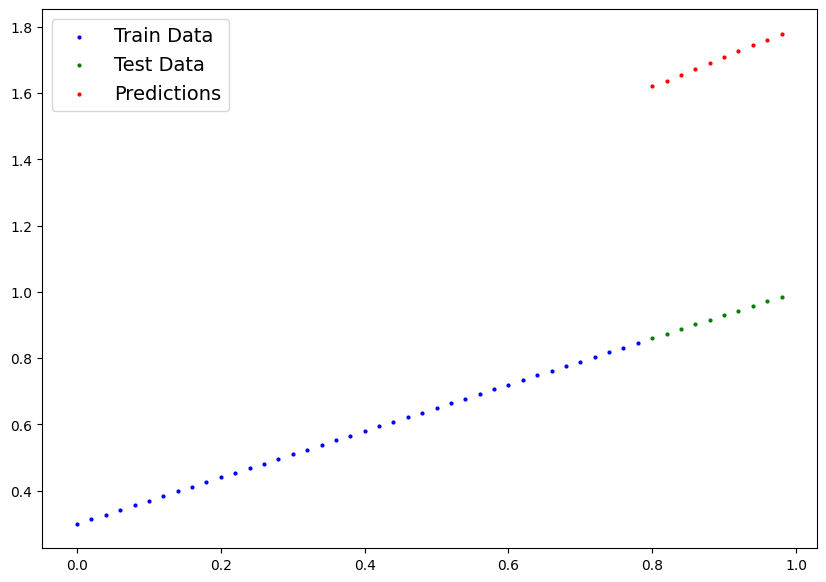

In [18]:
plot_predictions(predictions = y_preds)

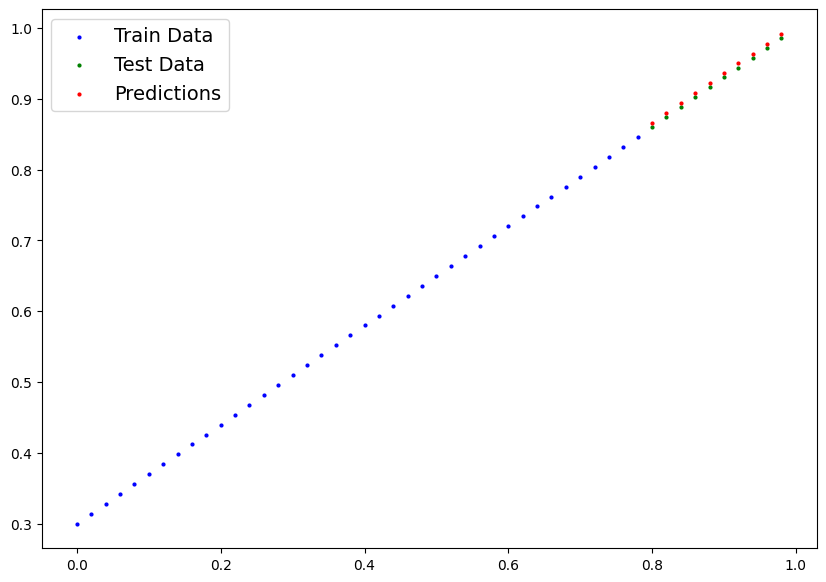

In [19]:
plot_predictions(predictions = y_preds_new)

## Saving a model in PyTorch (https://pytorch.org/tutorials/beginner/saving_loading_models.html)

There are three main methods for saving and loading models in PyTorch.

1. **torch.save()** -- Save PyTorch object in Python pickle format
2. **torch.load()** -- Load a saved PyTorch object
3. **torch.nn.Module.load_state_dict()** -- Load a model's saved state dictionary

In [20]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch Model

Since we saved state_dict() rather than entire model, we will create a new instance of our model class and load the saved state_dict into that

In [21]:
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])


In [22]:
# To load in a saved state_dict we have to instantiate new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
print(loaded_model_0.state_dict())

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])


# Building PyTorch Linear Model

In [23]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModel2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters (also called linear transform, probing layer, fully connected layer, dense layer)
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manuel seed
torch.manual_seed(42)
model_1 = LinearRegressionModel2()
print(model_1)
print(model_1.state_dict())

LinearRegressionModel2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


In [24]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [25]:
# Set the model to use the target device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### Training

For training we need:
* Loss Function
* Optimizer
* Training Loop
* Test Loop

In [26]:
# Setup Loss Function
loss_fn = nn.L1Loss() # Same ass MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01, )

In [27]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  train_loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  train_loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out whats happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Train Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
Epoch: 20 | Train Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Train Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
Epoch: 40 | Train Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Train Loss: 0.023886386305093765 | Test Loss: 0.04784906655550003
Epoch: 60 | Train Loss: 0.0199567973613739 | Test Loss: 0.04580312222242355
Epoch: 70 | Train Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Train Loss: 0.013089170679450035 | Test Loss: 0.029944902285933495
Epoch: 90 | Train Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Train Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 110 | Train Loss: 0.002787243574857712 | Test Loss: 0.005814164876937866
Epoch: 120 | Train Loss: 0.0012645035749301314 | Test Loss: 0.01380180753

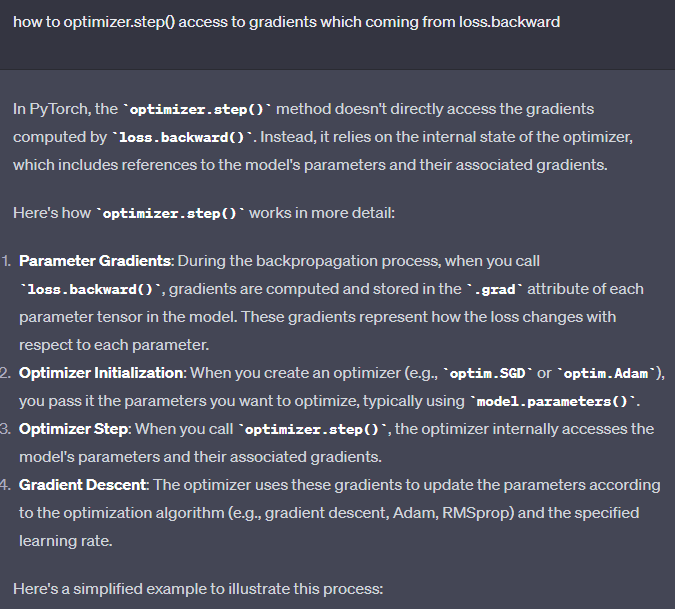

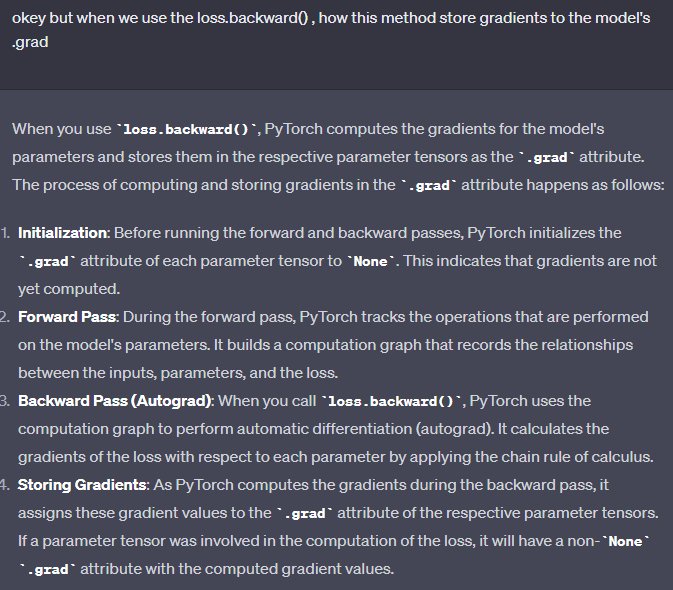

In [32]:
print(model_1.state_dict())

OrderedDict([('linear_layer.weight', tensor([[0.6968]])), ('linear_layer.bias', tensor([0.3025]))])


In [29]:
print(weight, bias)

0.7 0.3


## Making and evaluating predictions

In [30]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds2 = model_1(X_test)

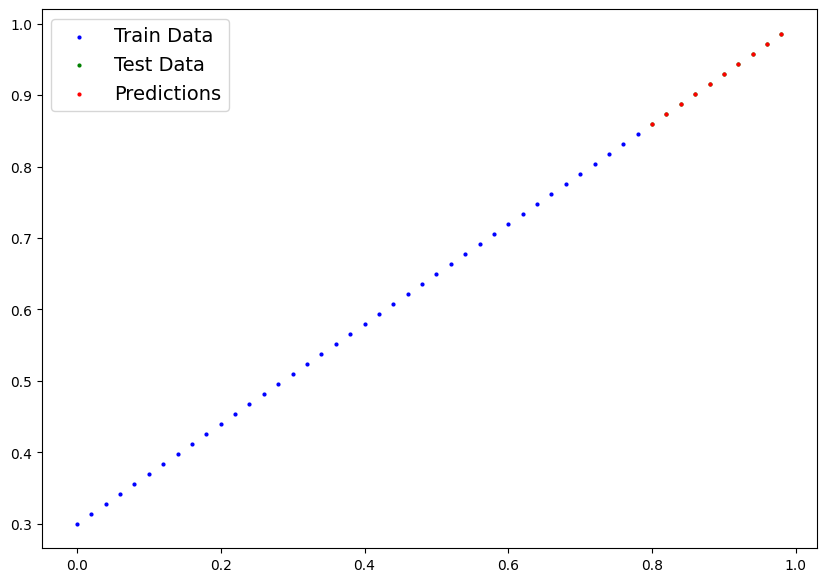

In [34]:
# Check out our model predictions visually
plot_predictions(predictions = y_preds2.cpu())